In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import classification_report
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.feature_extraction.text import CountVectorizer

/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
filename='X_train'
infile = open(filename,'rb')
X_train=pickle.load(infile)
infile.close()

filename='y_train'
infile = open(filename,'rb')
y_train=pickle.load(infile)
infile.close()

filename='X_test'
infile = open(filename,'rb')
X_test=pickle.load(infile)
infile.close()

filename='y_test'
infile = open(filename,'rb')
y_test=pickle.load(infile)
infile.close()

In [3]:
filename='TFIDF_W2V_Test_standarized_data'
infile = open(filename,'rb')
X_test_standarized_data=pickle.load(infile)
infile.close()

filename='TFIDF_W2V_Train_standarized_data'
infile = open(filename,'rb')
X_Train_standarized_data=pickle.load(infile)
infile.close()

In [17]:
filename='tfidfW2V_sent_vectors_Test'
infile = open(filename,'rb')
X_test_tfidfW2V=pickle.load(infile)
infile.close()

filename='tfidfW2V_sent_vectors_Train'
infile = open(filename,'rb')
X_Train_tfidfW2V=pickle.load(infile)
infile.close()

# GridSearch using L2 Regulizer

In [7]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
model.fit(X_Train_standarized_data, y_train)
print(model.best_estimator_)
print(model.score(X_test_standarized_data, y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8964391890381562


# GridSearch using L1 Regulizer

In [8]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
model.fit(X_Train_standarized_data, y_train)
print(model.best_estimator_)
print(model.score(X_test_standarized_data, y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8964638562296036


# Random searchCV

In [9]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = uniform(loc=0, scale=1)
hyperparameters = dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), hyperparameters, scoring = 'f1',cv=5, n_jobs=-1)
model.fit(X_Train_standarized_data, y_train)
print(model.best_estimator_)
print(model.score(X_test_standarized_data, y_test))

LogisticRegression(C=0.8428636112152159, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8964777400321831


# Comparing the Performance,Error and Sparsity on Varying the Hyper-Parameter using L1 Regularizer

In [10]:
for lamda in (10,0.1,0.01,0.001):
    log_reg = LogisticRegression(C=lamda, penalty='l1');
    log_reg.fit(X_Train_standarized_data, y_train);
    w = log_reg.coef_
    error=(1-log_reg.score(X_test_standarized_data, y_test))*100
    print ("For C=",lamda,"Non-Zero elements =" ,np.count_nonzero(w),"error=",error)
    print("\n")

('For C=', 10, 'Non-Zero elements =', 50, 'error=', 17.5952299570848)


('For C=', 0.1, 'Non-Zero elements =', 50, 'error=', 17.678781664198095)


('For C=', 0.01, 'Non-Zero elements =', 41, 'error=', 17.36736166495766)


('For C=', 0.001, 'Non-Zero elements =', 14, 'error=', 16.911625080703352)




It is observed that on increasing the lamda(1/C), the error of the model is increasing leading to underfit of the model and reducing the influence of loss term.

# Plotting Confusion matrix for Best Combination and better Accuracy Model

In [12]:
best_log_reg=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

best_log_reg.fit(X_Train_standarized_data, y_train)
# predict the response
pred = best_log_reg.predict(X_test_standarized_data)

In [13]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

('\nThe accuracy of the Logistitc Regression classifier(using BOW vectorization) is ', 82.4047700429152)

  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.49      0.36      0.42      4557
          1       0.87      0.92      0.90     21774

avg / total       0.81      0.82      0.81     26331


  CONFUSION MATRIX
[[ 1646  2911]
 [ 1722 20052]]

  Plot of CONFUSION MATRIX


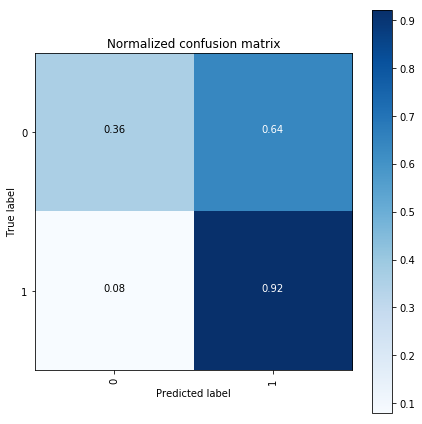

In [14]:
from sklearn.metrics import classification_report
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Logistitc Regression classifier(using BOW vectorization) is ',acc)

#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, pred)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, pred)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

# Multi Colinearity check:

In [15]:
w_Original=best_log_reg.coef_

In [16]:
w_Original

array([[-0.53495376,  0.32924108, -0.39144135,  0.09139121, -0.00245181,
         0.53336926, -0.64176161, -0.98621997,  0.21323041, -0.08726774,
         0.93819486,  0.04224673,  0.02688802, -0.1570975 ,  0.08568159,
         0.11167365, -0.19315135, -0.17860845,  0.16241489, -0.35089321,
         0.32765217, -0.33091496, -0.28772121,  0.14614684,  0.13002313,
         0.56142397,  0.11714822, -0.26478867,  0.11218678, -0.20861824,
        -0.19701278, -0.13739714, -0.27601405, -0.13958322,  0.34448573,
        -0.03033419, -0.24357783, -0.13980016, -0.17916213, -0.35047211,
        -0.22908409,  0.27048707,  0.10208014, -0.03812223,  0.45234672,
         0.43292951,  0.37445256,  0.35225269,  0.25076292,  0.09371438]])

In [28]:
noise = np.random.normal(0,1)
for i in range(len(X_Train_tfidfW2V)):
    for j in range(50):
        X_Train_tfidfW2V[i][j]+=noise

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_Train_standarized_data = scaler.fit_transform(X_Train_tfidfW2V)
X_Test_standarized_data = scaler.fit_transform(X_test_tfidfW2V)

In [30]:
best_log_reg=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

best_log_reg.fit(X_Train_standarized_data, y_train)
# predict the response
pred = best_log_reg.predict(X_Test_standarized_data)

In [31]:
w_noise = best_log_reg.coef_

In [32]:
w_noise

array([[-0.5349709 ,  0.32929161, -0.39145433,  0.09133974, -0.00250324,
         0.53350628, -0.64167525, -0.98622654,  0.21325832, -0.08739369,
         0.93824896,  0.04217979,  0.02684   , -0.157132  ,  0.08567696,
         0.1116578 , -0.19313282, -0.17865577,  0.16246008, -0.35083472,
         0.3275952 , -0.33093092, -0.28778768,  0.14615999,  0.13001389,
         0.56132379,  0.11711874, -0.26484469,  0.11230781, -0.20870973,
        -0.19703187, -0.13738934, -0.27601528, -0.13954351,  0.34439925,
        -0.03026634, -0.24354616, -0.1397571 , -0.17929241, -0.35049664,
        -0.22901905,  0.27058359,  0.10204408, -0.03818714,  0.45228647,
         0.43295809,  0.37445487,  0.35238268,  0.25081465,  0.0936692 ]])

In [33]:
count=0
sum=[count+1 for i in range(len(w_noise[0])) if (w_noise[0,i]-w_Original[0,i])/w_Original[0,i]>=0.4]

In [34]:
float(len(sum))/len(w_Original[0])

0.0

It is observered that there is ni=o multi-colinearity between the features.